# Assignment : Eastenders Gender Identification 

## Contents:
**Section 1:** Load data and packages

**Section 2:** Data preprocessing

**Section 3:** Data exploration

**Section 4:** Splitting data

**Section 5:** Model testing and analysis


## Section 1: Loading data and packages

In [1]:
# Loading packages 
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy

import collections
import json
import seaborn as sns
import wordcloud

import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from sklearn import feature_extraction, manifold
import gensim
import gensim.downloader as gensim_api

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [2]:
# loading data 
training_data = []
test_data = []

def load_data(path, data_name):
    with open(path) as f:
        reader = csv.reader(f, delimiter=',')
        for line in reader:
            (line, character, gender) = (line[0], line[1], line[2])
            data_name.append((line, character, gender))

# file paths
train_file_path = "training.csv"
test_file_path = "test.csv"

# sample of the training data
load_data(train_file_path, training_data)
load_data(test_file_path, test_data)

test_data[:3]

[('Kicked you out?', 'STACEY', 'female'),
 ('Meaning?', 'RONNIE', 'female'),
 ('Wish I could do more.', 'STEVEN', 'male')]

In [3]:
# creating dataframes
training_df = pd.DataFrame.from_records(training_data)
test_df = pd.DataFrame.from_records(test_data)

training_df.columns = ['TEXT', 'name', 'gender']
test_df.columns = ['TEXT', 'name', 'gender']


# dropping the 'name' feature
training_df = training_df.drop('name', axis=1)
training_df['gender'] = training_df['gender'].replace({'male': 0, 'female':1})


test_df = test_df.drop('name', axis=1)
test_df['gender'] = test_df['gender'].replace({'male': 0, 'female':1})
test_df.head()

,TEXT,gender
0,Kicked you out?,1
1,Meaning?,1
2,Wish I could do more.,0
3,What? Not you. Hang on. Pellets are in the cup...,1
4,"Yeah, he's not well. What? You don't believe m...",1


## Section 2: Data preprocessing

A function with various preprocessing methods was created. This allows for experiementing with various features to find the optimal combination.

The preprocessing features included the following:
 - Removal of punctuation and capital letters
 - Stopword removal
 - Lemmatisation of text
 - Stemming of text

In [4]:
# initialising stopwords and NER
en_stopwords = stopwords.words("english")
ner = spacy.load("en_core_web_sm")

def pre_process(text, punc=False, stem=False, lemm=False,
                stopwords=False, norm=False, NER=False, 
                POS=False, sentiment=False):


    tokens = word_tokenize(text)

    # puncuation removal
    if punc is True:
        joined_text = ' '.join(tokens)
        no_punc_text = re.sub(r'[^\w\s]', ' ', joined_text)
        tokens = no_punc_text.split()
        
    # normalise words
    if norm is True:
        tokens = [word.lower() for word in tokens]
    
    # copy of preprocessed normalised tokens without stemming, lemmatisation or stopword removal
    pre_norm_tokens = tokens.copy()
    
    # stopword removal
    if stopwords:
        tokens = [word for word in tokens if word not in en_stopwords]
    
    # lemmatiser
    if lemm:
        lemmat = WordNetLemmatizer()
        tokens = [lemmat.lemmatize(word) for word in tokens]

     # stemming
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
        
    text = ' '.join(tokens)
    return text

#### Examples of preprocess function 


In [5]:
print(test_data[3][0])
print(pre_process(test_data[3][0], punc=True, norm=True))
print(pre_process(test_data[3][0], stem=True))

What? Not you. Hang on. Pellets are in the cupboard.
what not you hang on pellets are in the cupboard
what ? not you . hang on . pellet are in the cupboard .


The punctuation in the text is removed and converted to lowercase in the column `clean_text`. The column `preprocessed_text` contains preprocessed text removing stopwords and other preprocessing features.

In [6]:

training_df['clean_text']= training_df['TEXT'].apply(lambda x: pre_process(x, punc=True,norm=True))
training_df['preprocessed_text']= training_df['TEXT'].apply(lambda x: 
                                               pre_process(x, lemm=True, norm=True, punc=True,
                                                          stopwords=True))
test_df['clean_text']= test_df['TEXT'].apply(lambda x: pre_process(x, punc=True,norm=True))
test_df['preprocessed_text']= test_df['TEXT'].apply(lambda x: 
                                               pre_process(x, lemm=True, norm=True, punc=True,
                                                          stopwords=True))
test_df.head()

,TEXT,gender,clean_text,preprocessed_text
0,Kicked you out?,1,kicked you out,kicked
1,Meaning?,1,meaning,meaning
2,Wish I could do more.,0,wish i could do more,wish could
3,What? Not you. Hang on. Pellets are in the cup...,1,what not you hang on pellets are in the cupboard,hang pellet cupboard
4,"Yeah, he's not well. What? You don't believe m...",1,yeah he s not well what you do n t believe me ...,yeah well n believe pop slip bed like old time...


## Section 3: Data exploration

Structural characteristics and dimensions of the text were evaluated as features for the model. The features that were considered were:
- Word count
- Character count
- Average word length

###### Sentence feature analysis 

The relationship between gender and the word count was investigated.

In [7]:
training_df['word_count'] = training_df['TEXT'].apply(lambda x: len(x.split(" ")))
training_df['character_count'] = training_df['TEXT'].apply(lambda x: sum(len(word) for word in x.split(' ')))
training_df['avg_word_length'] = training_df['character_count']/training_df['word_count']
training_df.head()

test_df['word_count'] = test_df['TEXT'].apply(lambda x: len(x.split(" ")))
test_df['character_count'] = test_df['TEXT'].apply(lambda x: sum(len(word) for word in x.split(' ')))
test_df['avg_word_length'] = test_df['character_count']/test_df['word_count']
test_df.head()

,TEXT,gender,clean_text,preprocessed_text,word_count,character_count,avg_word_length
0,Kicked you out?,1,kicked you out,kicked,3,13,4.333333
1,Meaning?,1,meaning,meaning,1,8,8.000000
2,Wish I could do more.,0,wish i could do more,wish could,5,17,3.400000
3,What? Not you. Hang on. Pellets are in the cup...,1,what not you hang on pellets are in the cupboard,hang pellet cupboard,10,43,4.300000
4,"Yeah, he's not well. What? You don't believe m...",1,yeah he s not well what you do n t believe me ...,yeah well n believe pop slip bed like old time...,22,90,4.090909


The below table shows the relationship between gender and features of the text.

In [8]:
sent_analysis_lst=['word_count', 'character_count', 'avg_word_length']
sent_analysis_df = training_df.groupby('gender')[sent_analysis_lst].mean().T
sent_analysis_df.columns=['male', 'female']

sent_analysis_df1 = test_df.groupby('gender')[sent_analysis_lst].mean().T
sent_analysis_df1.columns=['male', 'female']


###### Sentiment analysis

Using the pre-trained model, TextBlob, the sentiment of the text was analysed as a potential feature for the model. The table below shows the averages of the sentiment and subjectivity of between the genders. There is a small difference between the genders, and so the sentiment was considered as a potential feature.  


In [9]:
training_df["polarity_"] = training_df['TEXT'].apply(lambda x: TextBlob(x).sentiment.polarity)
training_df["subjectivity_"] = training_df['TEXT'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

sentiments = ['polarity_', 'subjectivity_']

sentiment_df_train = training_df.groupby('gender')[sentiments].mean()
sentiment_df_train.index=['male', 'female']

test_df["polarity_"] = test_df['TEXT'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df["subjectivity_"] = test_df['TEXT'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

sentiment_df_test = test_df.groupby('gender')[sentiments].mean()
sentiment_df_test.index=['male', 'female']



###### Punctuation 
The difference in punctuation between the genders was explored as feature. The following punctuation elements were evaluated.
 - Question marks (?)
 - Exclamation marks (!)
 - Pauses (...)
 
As there differences between the genders, they were used as features when testing the model.

In [10]:
training_df['question_marks_'] = training_df['TEXT'].apply(lambda x: x.count('?'))
training_df['exclamation_marks_'] = training_df['TEXT'].apply(lambda x: x.count('!'))
training_df['pauses_'] = training_df['TEXT'].apply(lambda x: x.count('...'))

punc_list = ['question_marks_', 'exclamation_marks_', 'pauses_']
question_df = pd.DataFrame(training_df.groupby('gender')[punc_list].mean())



test_df['question_marks_'] = test_df['TEXT'].apply(lambda x: x.count('?'))
test_df['exclamation_marks_'] = test_df['TEXT'].apply(lambda x: x.count('!'))
test_df['pauses_'] = test_df['TEXT'].apply(lambda x: x.count('...'))

question_df1 = pd.DataFrame(test_df.groupby('gender')[punc_list].mean())

question_df1

,question_marks_,exclamation_marks_,pauses_
gender,,,
0,0.428094,0.055184,0.145485
1,0.448669,0.060837,0.161597


###### Empty lines

Although uncommon, there were a few empty lines in the training data with women more likely to have empty lines.

In [11]:
empty_line_df = training_df[training_df['TEXT']=='']
empty_line_df['gender'].value_counts()

empty_line_df1 = test_df[test_df['TEXT']=='']
empty_line_df1['gender'].value_counts()

0    3
1    1
Name: gender, dtype: int64

In [12]:
training_df['empty_line'] = [1 if x =='' else 0 for x in training_df['TEXT']]


test_df['empty_line'] = [1 if x =='' else 0 for x in test_df['TEXT']]

test_df.head()

,TEXT,gender,clean_text,preprocessed_text,word_count,character_count,avg_word_length,polarity_,subjectivity_,question_marks_,exclamation_marks_,pauses_,empty_line
0,Kicked you out?,1,kicked you out,kicked,3,13,4.333333,0.0,0.0,1,0,0,0
1,Meaning?,1,meaning,meaning,1,8,8.000000,0.0,0.0,1,0,0,0
2,Wish I could do more.,0,wish i could do more,wish could,5,17,3.400000,0.5,0.5,0,0,0,0
3,What? Not you. Hang on. Pellets are in the cup...,1,what not you hang on pellets are in the cupboard,hang pellet cupboard,10,43,4.300000,0.0,0.0,1,0,0,0
4,"Yeah, he's not well. What? You don't believe m...",1,yeah he s not well what you do n t believe me ...,yeah well n believe pop slip bed like old time...,22,90,4.090909,0.1,0.2,1,0,0,0


## Section 4: Splitting data


In [13]:
processed_train_df = training_df.copy()
processed_test_df = test_df.copy()

y1_train = processed_train_df['gender']
X1_train = processed_train_df.drop(['gender'], axis=1)

y1_test = processed_test_df['gender']
X1_test = processed_test_df.drop(['gender'], axis=1)


In [14]:
processed_train_df = training_df.copy()
y = processed_train_df['gender']
X = processed_train_df.drop(['gender'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=42)

In [15]:
X_test.head()

,TEXT,clean_text,preprocessed_text,word_count,character_count,avg_word_length,polarity_,subjectivity_,question_marks_,exclamation_marks_,pauses_,empty_line
9571,No argument there. Talk about asking for trou...,no argument there talk about asking for troubl...,argument talk asking trouble bound get caught,17,69,4.058824,-0.2,0.2,0,0,0,0
9502,Look you don't -,look you do n t,look n,4,13,3.250000,0.0,0.0,0,0,0,0
3379,Well?,well,well,1,5,5.000000,0.0,0.0,1,0,0,0
5407,I thought you didn't want to go?,i thought you did n t want to go,thought n want go,7,26,3.714286,0.0,0.0,1,0,0,0
7815,‚S not much of a challenge.,s not much of a challenge,much challenge,6,22,3.666667,-0.1,0.2,0,0,0,0


## Section 5: Model testing and analysis

A selector transformer was made to return either a numerical or categorical column.

The features that are numerical were grouped together for use in feature analysis and are shown below

In [16]:
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are:\n{str(numerical)}")


Numerical columns are:
['word_count', 'character_count', 'avg_word_length', 'polarity_', 'subjectivity_', 'question_marks_', 'exclamation_marks_', 'pauses_', 'empty_line']


In [17]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]
    
    def get_feature_names(self):
        return self.columns.tolist()
    
class NumSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.columns]]

    def get_feature_names(self):
        return self.columns.tolist()

The preprocessed text was vectorized into a Bag of Words (BoW) model and subsequently transformed using TF-IDF. Features such as word count, polarity and pauses were then preprocessed using MinMaxScaler normalisation.

All features were then joined in a feature union.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score


pp_text = Pipeline([
                ('selector', TextSelector(columns='preprocessed_text')),
                ('bow', CountVectorizer()),
                ('tfidf', TfidfTransformer())
            ])

In [19]:
word_count =  Pipeline([
                ('selector', NumSelector(columns='word_count')),
                ('min_max', MinMaxScaler())
            ])
character_count =  Pipeline([
                ('selector', NumSelector(columns='character_count')),
                ('min_max', MinMaxScaler())
            ])
avg_word_length =  Pipeline([
                ('selector', NumSelector(columns='avg_word_length')),
                ('min_max', MinMaxScaler())
            ])
polarity_ =  Pipeline([
                ('selector', NumSelector(columns='polarity_')),
                ('min_max', MinMaxScaler())
            ])
subjectivity_ =  Pipeline([
                ('selector', NumSelector(columns='subjectivity_')),
                ('min_max', MinMaxScaler())
            ])
question_marks_ =  Pipeline([
                ('selector', NumSelector(columns='question_marks_')),
                ('min_max', MinMaxScaler())
            ])
exclamation_marks_ =  Pipeline([
                ('selector', NumSelector(columns='exclamation_marks_')),
                ('min_max', MinMaxScaler())
            ])
pauses_ =  Pipeline([
                ('selector', NumSelector(columns='pauses_')),
                ('min_max', MinMaxScaler())
            ])
empty_line =  Pipeline([
                ('selector', NumSelector(columns='empty_line')),
                ('min_max', MinMaxScaler())
            ])

In [20]:
feat_union = Pipeline([
    ('feature_union', FeatureUnion(
        [('pp_text', pp_text), 
        ('word_count', word_count),
        ('character_count', character_count),
        ('avg_word_length', avg_word_length),
        ('polarity_', polarity_),
        ('subjectivity_', subjectivity_),
        ('question_marks_', question_marks_),
        ('exclamation_marks_', exclamation_marks_),
        ('pauses_', pauses_),
        ('empty_line', empty_line)]))])


feat_processing = Pipeline([('feats', feat_union)])


### Classifier selection:

The following classifiers were evaluated:
1. Random Forest Classifier
2. Naive Bayes Classifier
    1. Multinomial Naive Bayes
    2. Complement Naive Bayes
3. Logistic Regression
4. Decision Tree
5. Support Vector Machine

#### Classifier 1: Random Forest Tree


Random Forest Classifier f-score: 0.5550

              precision    recall  f1-score   support

           0       0.56      0.57      0.57      1006
           1       0.56      0.55      0.55      1017

    accuracy                           0.56      2023
   macro avg       0.56      0.56      0.56      2023
weighted avg       0.56      0.56      0.56      2023



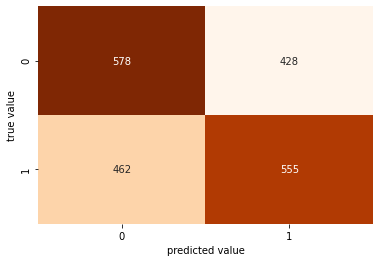

In [21]:
# rfc pipeline
rfc_pipeline = Pipeline([
    ('features',feat_union),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
rfc_pipeline.fit(X_train, y_train)
rfc_preds = rfc_pipeline.predict(X_test)

# Cross validation for the f-score
rfc_score = f1_score(y_test,rfc_preds)
print(f'Random Forest Classifier f-score: {rfc_score.mean():.4f}\n')
print(classification_report(y_test, rfc_preds))

rfc_mat = confusion_matrix(y_test, rfc_preds)
sns.heatmap(rfc_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');


#### Classifier 2a: Multinomial Naive Bayes Classifier
Multinomial Naive Bayes was evaluated. The f-score and confusion matrix produced are given below.

Multinomial Naive Bayes Classifier f-score: 0.5569

              precision    recall  f1-score   support

           0       0.56      0.60      0.58      1006
           1       0.58      0.54      0.56      1017

    accuracy                           0.57      2023
   macro avg       0.57      0.57      0.57      2023
weighted avg       0.57      0.57      0.57      2023



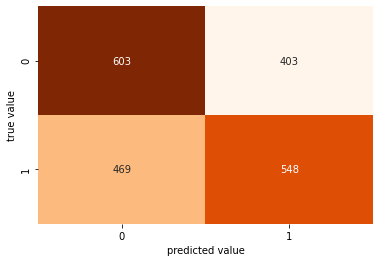

In [22]:
# MNB pipeline
MNB_pipeline = Pipeline([
    ('features',feat_union),
    ('classifier', MultinomialNB()),
])
MNB_pipeline.fit(X_train, y_train)
MNB_preds = MNB_pipeline.predict(X_test)

# Cross validation for the f-score
MNB_score = f1_score(y_test,MNB_preds)

print(f'Multinomial Naive Bayes Classifier f-score: {MNB_score:.4f}\n')
print(classification_report(y_test, MNB_preds))

MNB_mat = confusion_matrix(y_test, MNB_preds)
sns.heatmap(MNB_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');


#### Classifier 2b: Complement Naive Bayes Classifier
Complement Naive Bayes is typically better with imbalanced data sets such as NLP. As the f-score and confusion matrix below show, it is an improvement on the Multinomial Naive Bayes model.

Complement Naive Bayes Classifier f-score: 0.5822

              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1006
           1       0.59      0.58      0.58      1017

    accuracy                           0.58      2023
   macro avg       0.58      0.58      0.58      2023
weighted avg       0.58      0.58      0.58      2023



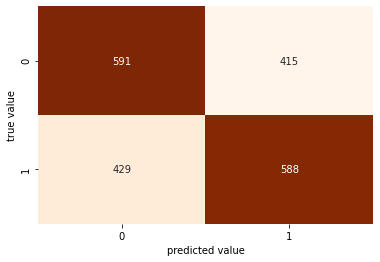

In [23]:
# CNB pipeline
CNB_pipeline = Pipeline([
    ('features',feat_union),
    ('classifier', ComplementNB()),
])
CNB_pipeline.fit(X_train, y_train)
CNB_preds = CNB_pipeline.predict(X_test)

# Cross validation for the f-score
CNB_score = f1_score(y_test,CNB_preds)

print(f'Complement Naive Bayes Classifier f-score: {CNB_score:.4f}\n')
print(classification_report(y_test, CNB_preds))

CNB_mat = confusion_matrix(y_test, CNB_preds)
sns.heatmap(CNB_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');


#### Classifier 3: Logistic Regression Classifier 


Logistic Regression Classifier f-score: 0.5784

              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1006
           1       0.59      0.57      0.58      1017

    accuracy                           0.58      2023
   macro avg       0.58      0.58      0.58      2023
weighted avg       0.58      0.58      0.58      2023



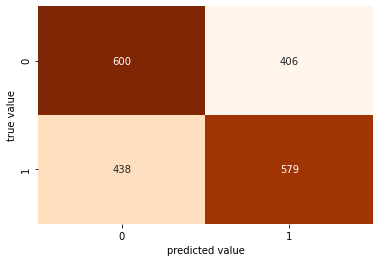

In [24]:
LR_pipeline = Pipeline([
    ('features',feat_union),
    ('classifier', LogisticRegression()),
])
LR_pipeline.fit(X_train, y_train)
LR_preds = LR_pipeline.predict(X_test)

# Cross validation for the f-score
LR_score = f1_score(y_test,LR_preds)

print(f'Logistic Regression Classifier f-score: {LR_score.mean():.4f}\n')
print(classification_report(y_test, LR_preds))

LR_mat = confusion_matrix(y_test, LR_preds)
sns.heatmap(LR_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');


#### Classifier 4: Decision Tree


Decision Tree Classifier f-score: 0.5136

              precision    recall  f1-score   support

           0       0.51      0.52      0.52      1006
           1       0.52      0.51      0.51      1017

    accuracy                           0.52      2023
   macro avg       0.52      0.52      0.52      2023
weighted avg       0.52      0.52      0.52      2023



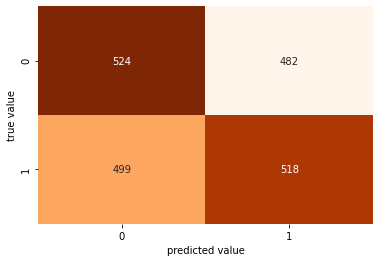

In [25]:
DT_pipeline = Pipeline([
    ('features',feat_union),
    ('classifier', DecisionTreeClassifier()),
])
DT_pipeline.fit(X_train, y_train)
DT_preds = DT_pipeline.predict(X_test)

# Cross validation for the f-score
DT_score = f1_score(y_test,DT_preds)

print(f'Decision Tree Classifier f-score: {DT_score.mean():.4f}\n')
print(classification_report(y_test, DT_preds))

DT_mat = confusion_matrix(y_test, DT_preds)
sns.heatmap(DT_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');


#### Classifier 5: Support Vector Machine


In [26]:
SVM_pipeline = Pipeline([
    ('features',feat_union),
    ('classifier', LinearSVC()),
])
SVM_pipeline.fit(X_train, y_train)
SVM_preds = SVM_pipeline.predict(X_test)

# Cross validation for the f-score
SVM_score = f1_score(y_test,SVM_preds)

print(f'Support Vector Machine classifier f-score: {SVM_score.mean():.4f}')
print(classification_report(y_test, SVM_preds))

Support Vector Machine classifier f-score: 0.5709
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      1006
           1       0.58      0.56      0.57      1017

    accuracy                           0.58      2023
   macro avg       0.58      0.58      0.58      2023
weighted avg       0.58      0.58      0.58      2023



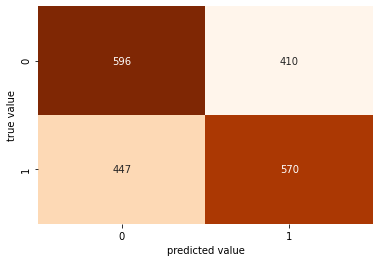

In [27]:
SVM_mat = confusion_matrix(y_test, SVM_preds)
sns.heatmap(SVM_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');

### Logistic Regression Classifier VS Complement Naive Bayes Classifier


In [28]:
# selection of hyperparameters
hyperparameters = { 'features__feature_union__pp_text__bow__max_df': [0.05, 0.25, 0.5,0.75, 0.95],
                    'features__feature_union__pp_text__bow__ngram_range': [(1,1), (1,2), (1,3)],
                    'features__feature_union__pp_text__bow__strip_accents':[None, 'ascii']
                  }

The best parameters were:


{'features__feature_union__pp_text__bow__max_df': 0.25,
 'features__feature_union__pp_text__bow__ngram_range': (1, 1),
 'features__feature_union__pp_text__bow__strip_accents': 'ascii'}


CNB f-score: 0.5823

              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1006
           1       0.59      0.58      0.58      1017

    accuracy                           0.58      2023
   macro avg       0.58      0.58      0.58      2023
weighted avg       0.58      0.58      0.58      2023



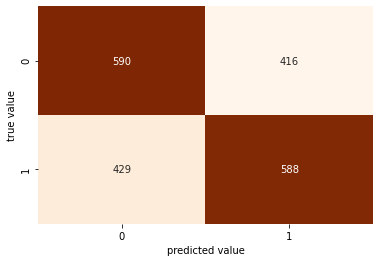

In [29]:
CNB_clf = GridSearchCV(CNB_pipeline, hyperparameters, cv=5)

# Fit and tune model
CNB_clf.fit(X_train, y_train)

# best parameters
print('The best parameters were:')
display(CNB_clf.best_params_)

CNB_clf.refit
CNB_preds = CNB_clf.predict(X_test)

CNB_CV_score = np.mean(CNB_preds == y_test)
print(f'\nCNB f-score: {CNB_CV_score:.4f}\n')
print(classification_report(y_test, CNB_preds))

CNB_best_mat = confusion_matrix(y_test, CNB_preds)
sns.heatmap(CNB_best_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');

# TEST DATA CLASSIFICATION: COMPLIMENT NAIVE BAYES


CNB f-score: 0.5703

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       598
           1       0.54      0.59      0.56       526

    accuracy                           0.57      1124
   macro avg       0.57      0.57      0.57      1124
weighted avg       0.57      0.57      0.57      1124



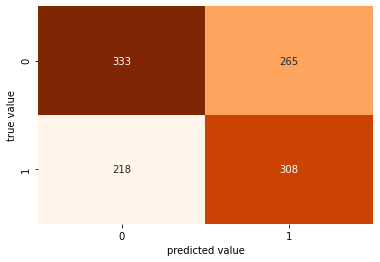

In [30]:
TEST_DATA_CNB_preds = CNB_clf.predict(X1_test)

CNB_CV_score = np.mean(TEST_DATA_CNB_preds == y1_test)
print(f'\nCNB f-score: {CNB_CV_score:.4f}\n')
print(classification_report(y1_test, TEST_DATA_CNB_preds))

CNB_best_mat = confusion_matrix(y1_test, TEST_DATA_CNB_preds)
sns.heatmap(CNB_best_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');

The best parameters were:


{'features__feature_union__pp_text__bow__max_df': 0.05,
 'features__feature_union__pp_text__bow__ngram_range': (1, 2),
 'features__feature_union__pp_text__bow__strip_accents': None}

\LR f-score: 0.5679

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      1006
           1       0.58      0.56      0.57      1017

    accuracy                           0.57      2023
   macro avg       0.57      0.57      0.57      2023
weighted avg       0.57      0.57      0.57      2023



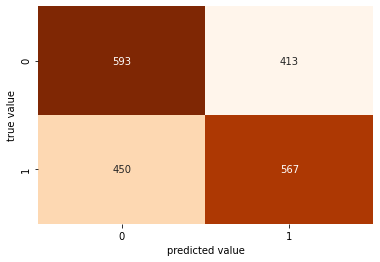

In [31]:
LR_clf = GridSearchCV(LR_pipeline, hyperparameters, cv=5)
 
# Fit and tune model
LR_clf.fit(X_train, y_train)

# best parameters
print('The best parameters were:')
display(LR_clf.best_params_)

LR_clf.refit
LR_preds = LR_clf.predict(X_test)

LR_CV_score = f1_score(y_test,LR_preds)

print(f'\LR f-score: {LR_CV_score:.4f}\n')
print(classification_report(y_test, LR_preds))

LR_best_mat = confusion_matrix(y_test, LR_preds)
sns.heatmap(LR_best_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');


# TEST DATA CLASSIFICATION: LOGISITIC REGRESSION


CNB f-score: 0.5703

              precision    recall  f1-score   support

           0       0.58      0.55      0.57       598
           1       0.52      0.55      0.54       526

    accuracy                           0.55      1124
   macro avg       0.55      0.55      0.55      1124
weighted avg       0.56      0.55      0.55      1124



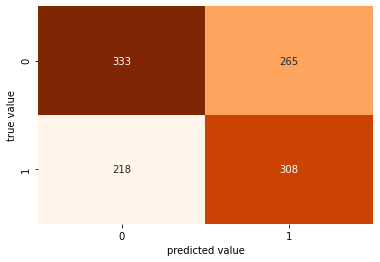

In [32]:
TEST_DATA_LR_preds = LR_clf.predict(X1_test)

LR_CV_score = np.mean(TEST_DATA_LR_preds == y1_test)
print(f'\nCNB f-score: {CNB_CV_score:.4f}\n')
print(classification_report(y1_test, TEST_DATA_LR_preds))

LR_best_mat = confusion_matrix(y1_test, TEST_DATA_LR_preds)
sns.heatmap(CNB_best_mat, annot=True, cbar=False, fmt='d',cmap=plt.cm.Oranges) 
plt.xlabel('predicted value')
plt.ylabel('true value');